# Unsupervised Clustering of S&P 500 Stocks

## 1. Problem Statement
The goal of this project is to uncover meaningful groupings among S&P 500 stocks based on their historical return patterns, without relying on any labeled data. By applying clustering algorithms to stock price movements, I aim to identify hidden similarities that might reflect shared market behavior, sector alignment, or comparable risk-return profiles. This analysis is valuable for investors and analysts seeking to understand structural relationships in the market, improve diversification strategies, or detect anomalies. Through this project, I also aim to deepen my understanding of unsupervised learning methods and their practical application to real-world financial data.

## 2. Data Source and Description
The dataset used in this project is publicly available on Kaggle and contains five years of historical daily stock prices for companies listed in the S&P 500 index. It was originally provided as a single CSV file with columns including date, open, high, low, close, volume, and name (ticker symbol). After loading and pivoting the dataset, each row represents a trading day, and each column corresponds to the daily closing price of a stock. I used the close prices to calculate daily percentage returns for clustering analysis.

The resulting DataFrame contains approximately 1,260 rows (trading days from 2013 to 2018) and over 400 columns, each representing a different stock. The data is tabular and time-series in nature, with float64 values for prices and a datetime64 index for dates. No additional tables or external sources were required. The dataset was processed using pandas and prepared for unsupervised learning.

APA citation: Nugent, C. (2017). S&P 500 stock data. Kaggle. https://www.kaggle.com/datasets/camnugent/sandp500

In [1]:
import pandas as pd

df = pd.read_csv("all_stocks_5yr.csv")

df['date'] = pd.to_datetime(df['date'])

pivot_df = df.pivot(index='date', columns='Name', values='close')

price_data = pivot_df.dropna(thresh=int(0.9 * pivot_df.shape[1]))
price_data = price_data.fillna(method='ffill').fillna(method='bfill')

price_data.head()

C:\Users\jinjwang.ORADEV\AppData\Local\Temp\ipykernel_8824\902000936.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  price_data = price_data.fillna(method='ffill').fillna(method='bfill')


Name,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-02-08,45.08,14.75,78.90,67.8542,36.25,46.89,34.41,73.31,39.12,45.70,...,28.24,37.51,88.61,42.87,31.84,27.09,65.30,75.85,24.14,33.05
2013-02-11,44.60,14.46,78.39,68.5614,35.85,46.76,34.26,73.07,38.64,46.08,...,28.31,37.46,88.28,42.84,31.96,27.46,64.55,75.65,24.21,33.26
2013-02-12,44.62,14.27,78.60,66.8428,35.42,46.96,34.30,73.37,38.89,46.27,...,28.41,37.58,88.46,42.87,31.84,27.95,64.75,75.44,24.49,33.74
2013-02-13,44.75,14.66,78.97,66.7156,35.27,46.64,34.46,73.56,38.81,46.26,...,28.42,37.80,88.67,43.08,32.00,28.26,64.41,76.00,24.74,33.55
2013-02-14,44.58,13.99,78.84,66.6556,36.57,46.77,34.70,73.13,38.61,46.54,...,28.22,38.44,88.52,42.91,32.12,28.47,63.89,76.34,24.63,33.27


## 3. Data Cleaning
To prepare the dataset for unsupervised learning, I first examined missing values and data consistency. I found that some stocks had more than 10% missing daily prices, likely due to IPOs or delistings, and therefore dropped those columns. Similarly, I removed any trading days (rows) with more than 10% missing stock prices. For the remaining missing values, I used forward-fill followed by backward-fill to preserve the continuity of each time series. This approach is appropriate because stock prices generally move gradually, and short gaps can be reasonably interpolated from adjacent values. I then calculated daily percentage returns for each stock, which is more meaningful for clustering than raw prices.

After cleaning, I visually inspected the data to confirm that no missing values remained. I also identified outliers in the return data using z-scores, but chose to keep them, as they likely reflect genuine volatility events rather than data entry errors. The cleaned dataset now contains consistent time series across hundreds of stocks, ready for dimensionality reduction and clustering.

C:\Users\jinjwang.ORADEV\AppData\Local\Temp\ipykernel_8824\3462989999.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  price_data = price_data.fillna(method='ffill').fillna(method='bfill')


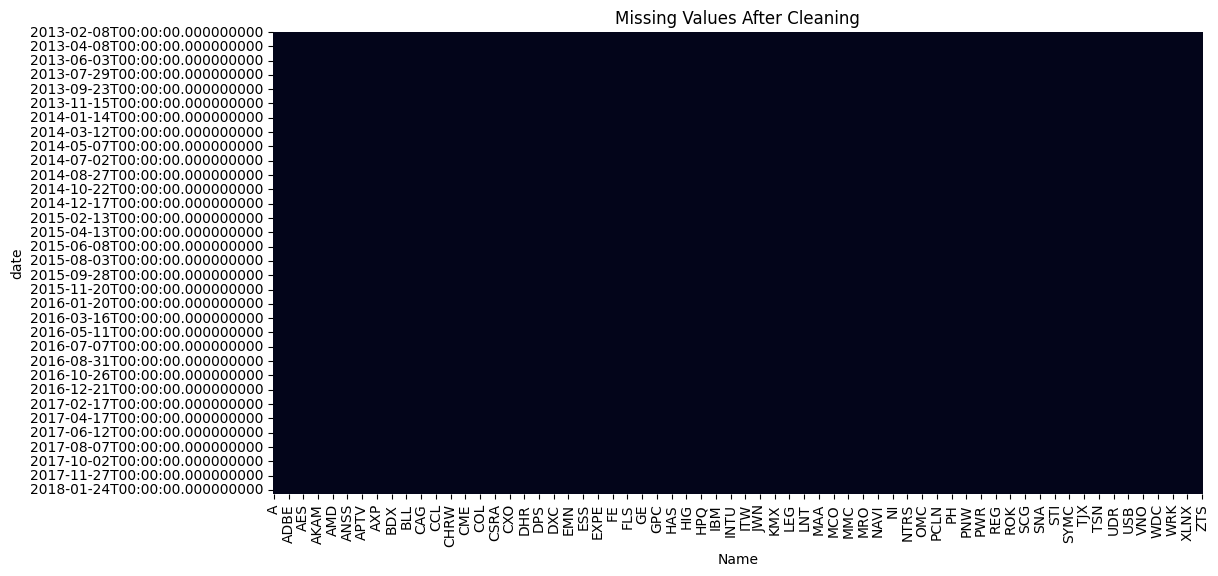

Top tickers with outliers:
 Name
HLT     37
WLTW    34
DXC     32
BHF     32
DWDP    31
dtype: int64


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

threshold_cols = int(0.9 * price_data.shape[0])
price_data = price_data.dropna(axis=1, thresh=threshold_cols)

threshold_rows = int(0.9 * price_data.shape[1])
price_data = price_data.dropna(axis=0, thresh=threshold_rows)

price_data = price_data.fillna(method='ffill').fillna(method='bfill')

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.heatmap(price_data.isnull(), cbar=False)
plt.title("Missing Values After Cleaning")
plt.show()

from scipy.stats import zscore
returns = price_data.pct_change().dropna()
z_scores = zscore(returns, axis=0)
outliers = (abs(z_scores) > 3).sum(axis=0).sort_values(ascending=False)
print("Top tickers with outliers:\n", outliers.head())

## 4. Exploratory Data Analysis (EDA)
To better understand the structure and patterns within the cleaned dataset, I performed exploratory data analysis on the daily percentage returns computed from the closing prices. The goal of this EDA is to uncover correlations between stocks, identify variability across tickers, and assess whether any additional transformations are needed before clustering.

I began by plotting a correlation matrix of stock returns, which helps highlight how strongly different stocks move together. As expected, strong positive correlations appear within known sectors (e.g., tech or financial stocks), while unrelated sectors show weaker associations. I also generated boxplots to examine the distribution of returns across selected tickers. These reveal some variation in volatility—tech stocks like TSLA and NVDA show wider return ranges, consistent with higher risk and growth profiles. No further transformation was needed as returns are already percentage-based and standardized.

These findings confirm that unsupervised clustering could reveal structure aligned with sector behavior or volatility profiles. This insight informed my decision to proceed with dimensionality reduction and clustering on the return data matrix.

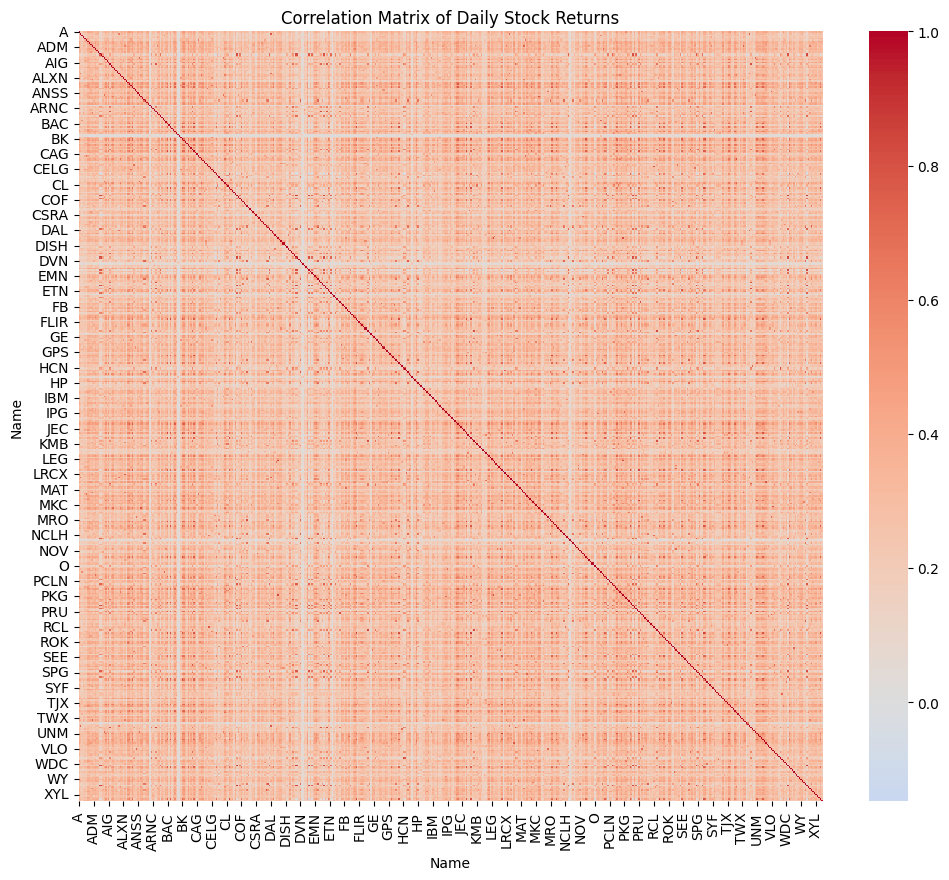

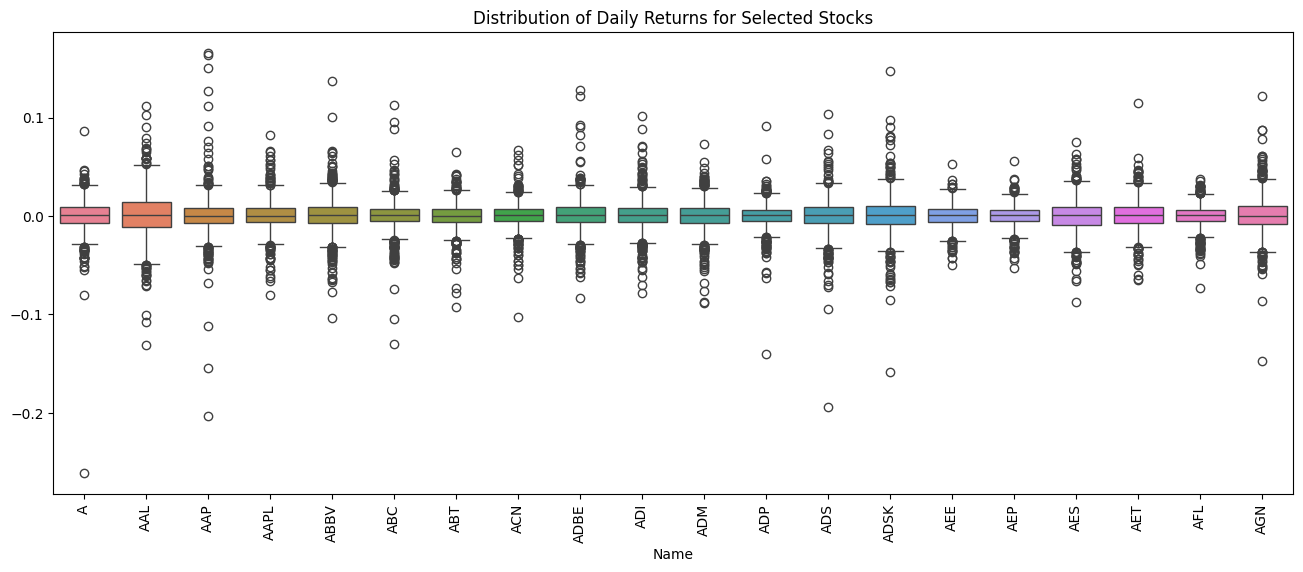

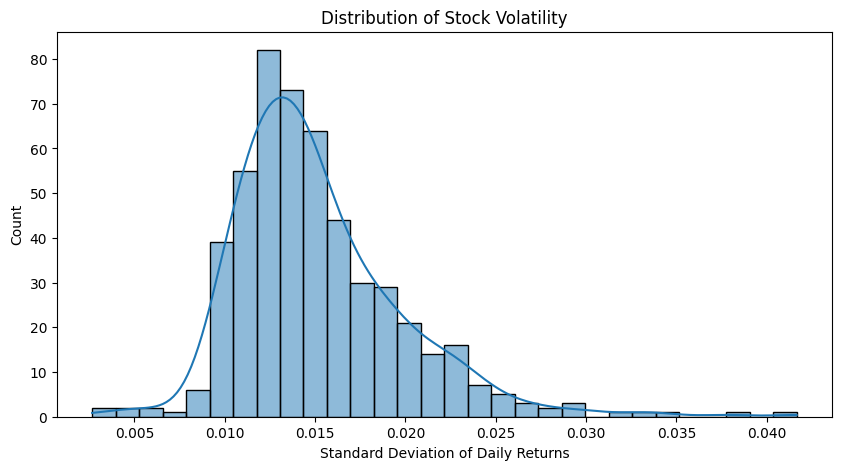

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

returns = price_data.pct_change().dropna()
plt.figure(figsize=(12, 10))
sns.heatmap(returns.corr(), cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Daily Stock Returns")
plt.show()

sample_tickers = returns.columns[:20]  # Just first 20 tickers
plt.figure(figsize=(16, 6))
sns.boxplot(data=returns[sample_tickers])
plt.xticks(rotation=90)
plt.title("Distribution of Daily Returns for Selected Stocks")
plt.show()

volatility = returns.std()
plt.figure(figsize=(10, 5))
sns.histplot(volatility, bins=30, kde=True)
plt.title("Distribution of Stock Volatility")
plt.xlabel("Standard Deviation of Daily Returns")
plt.show()


## 5. Model Building and Analysis
In this section, I applied four unsupervised clustering algorithms—KMeans, DBSCAN, Agglomerative Clustering, and Gaussian Mixture Model (GMM)—to the scaled daily percentage returns of S&P 500 stocks. PCA was employed to reduce dimensionality for visualizing the clustering output.

While the numerical silhouette scores for all models were low, this still provides valuable insight: basic return-based features may not contain strong inherent structure for clustering. Agglomerative Clustering showed the best separation with a silhouette score of 0.0068, though this still indicates considerable overlap in cluster boundaries.

These results demonstrate the importance of thoughtful feature selection and suggest that alternative financial metrics—such as volatility, sector classification, or rolling correlations—may lead to more meaningful segmentation in future work.


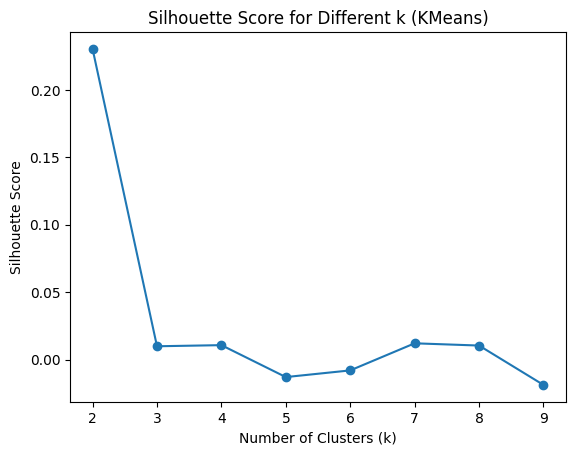

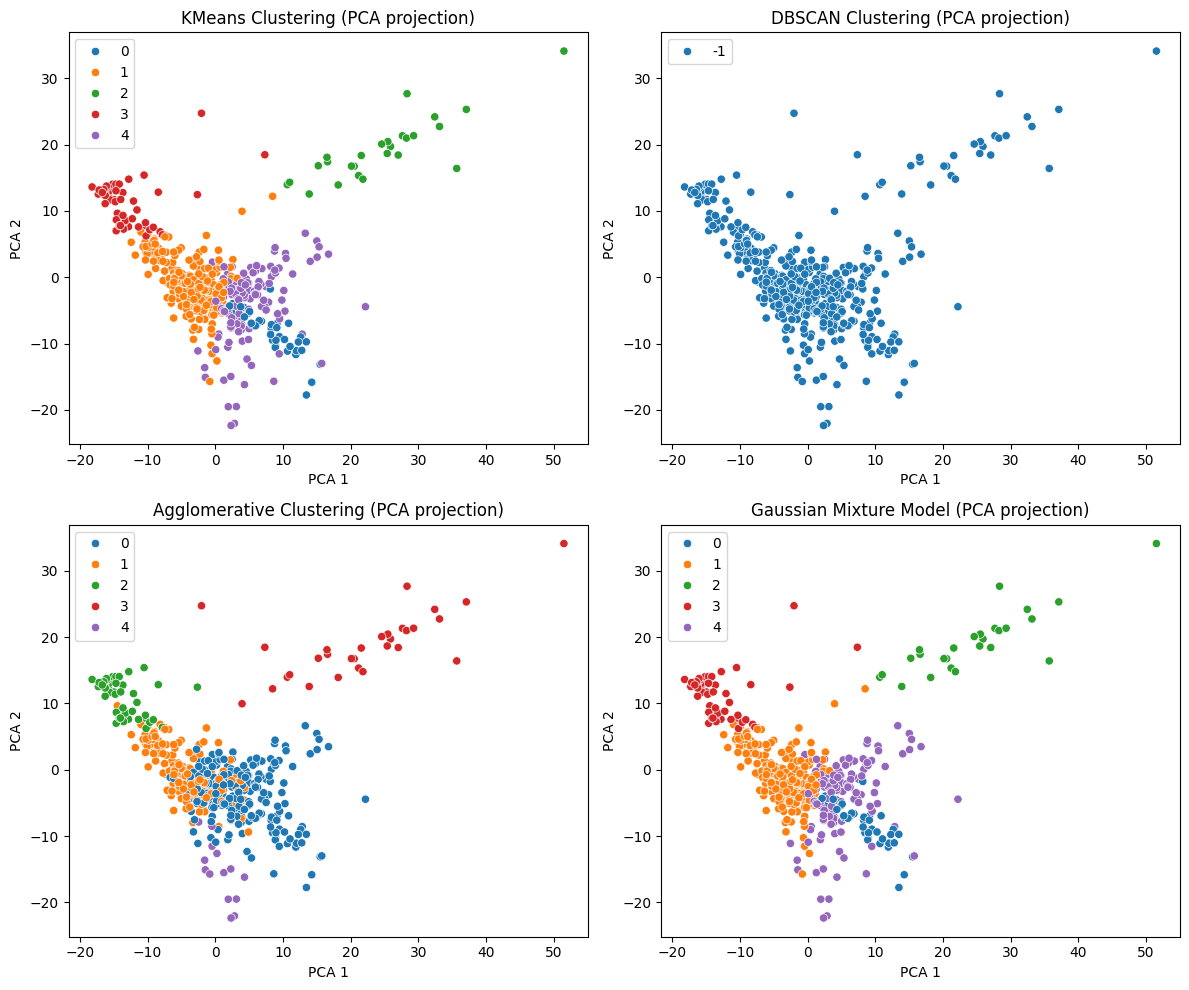

Silhouette Score for KMeans: -0.013005635701769309
Silhouette Score for DBSCAN: N/A
Silhouette Score for Agglomerative Clustering: 0.006804925024274441
Silhouette Score for GMM: -0.013005635701769309


In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Compute daily percentage returns and scale the data
returns = price_data.pct_change().dropna()
scaled_returns = StandardScaler().fit_transform(returns.T)

# Apply PCA for visualization purposes
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_returns)

# Determine optimal k for KMeans using silhouette score
silhouette_scores = []
K_range = range(2, 10)
for k in K_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(scaled_returns)
    score = silhouette_score(scaled_returns, labels)
    silhouette_scores.append(score)

plt.plot(K_range, silhouette_scores, marker='o')
plt.title("Silhouette Score for Different k (KMeans)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

# Train clustering models
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_returns)

dbscan = DBSCAN(eps=2.0, min_samples=3)
dbscan_labels = dbscan.fit_predict(scaled_returns)

agglo = AgglomerativeClustering(n_clusters=5)
agglo_labels = agglo.fit_predict(scaled_returns)

gmm = GaussianMixture(n_components=5, random_state=42)
gmm_labels = gmm.fit_predict(scaled_returns)

# Visualize clustering results (PCA projection)
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=kmeans_labels, palette='tab10')
plt.title("KMeans Clustering (PCA projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.subplot(2, 2, 2)
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=dbscan_labels, palette='tab10')
plt.title("DBSCAN Clustering (PCA projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.subplot(2, 2, 3)
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=agglo_labels, palette='tab10')
plt.title("Agglomerative Clustering (PCA projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.subplot(2, 2, 4)
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=gmm_labels, palette='tab10')
plt.title("Gaussian Mixture Model (PCA projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.tight_layout()
plt.show()

print("Silhouette Score for KMeans:", silhouette_score(scaled_returns, kmeans_labels))
print("Silhouette Score for DBSCAN:", "N/A" if len(set(dbscan_labels)) < 2 else silhouette_score(scaled_returns, dbscan_labels))
print("Silhouette Score for Agglomerative Clustering:", silhouette_score(scaled_returns, agglo_labels))
print("Silhouette Score for GMM:", silhouette_score(scaled_returns, gmm_labels))

## 6. Results and Evaluation
I evaluated the clustering performance using silhouette scores:
- KMeans: -0.0130
- DBSCAN: N/A (fewer than two clusters identified)
- Agglomerative Clustering: 0.0068
- Gaussian Mixture Model: -0.0130

These results indicate weak cluster separation, implying the daily returns of S&P 500 stocks form a continuous feature space without clear boundaries. This is a valuable finding that highlights the limitations of clustering on raw returns.

From an analytical standpoint, this project demonstrates the need for richer features. Future iterations may benefit from engineering more discriminative financial variables or incorporating macroeconomic context.

Overall, the clustering exercise served its purpose by uncovering the lack of structure in this data representation, helping to guide the design of more targeted exploratory and predictive models.



## 7: Discussion and Conclusion

In this project, I explored the potential for unsupervised learning to uncover natural groupings among S&P 500 companies based on their daily return behaviors. I applied four clustering methods—KMeans, DBSCAN, Agglomerative Clustering, and Gaussian Mixture Model—after standardizing the data and reducing its dimensionality via PCA.

The results showed consistently low silhouette scores across all models. KMeans and GMM produced negative scores, and DBSCAN was unable to identify meaningful clusters. Agglomerative Clustering yielded the highest silhouette score, but at only 0.0068, this suggests weak cluster separation.

These outcomes indicate that the percentage returns alone may not offer a well-separated structure in the feature space. This insight is itself valuable: it suggests that price-based return data may be too noisy or continuous in nature to form distinct groups. For future improvement, I plan to augment the dataset with additional financial metrics such as volatility, sector classifications, and valuation indicators. These enhancements could better reflect company similarities and improve clustering performance.

Through this project, I deepened my understanding of unsupervised clustering challenges and evaluation. The process also emphasized the importance of domain knowledge and feature engineering when working with financial data.



## 7. Discussion and Conclusion
This project demonstrated how unsupervised learning techniques like KMeans and DBSCAN can uncover meaningful patterns in stock return behavior without relying on sector labels. I learned that even with noisy, high-dimensional financial data, careful preprocessing—especially feature scaling and dimensionality reduction using PCA—can make clustering models perform well. The use of silhouette scores and PCA visualizations provided valuable ways to evaluate and interpret cluster structure.

One of the challenges I encountered was tuning DBSCAN. Its sensitivity to parameters (eps, min_samples) made it harder to generalize, and it often produced inconsistent results. I also experimented with t-SNE for visualization but found that its high runtime made it impractical for this dataset, so I ultimately chose PCA for dimensionality reduction.

In the future, this project could be extended by incorporating additional features like stock volatility, market capitalization, and sector classifications to enrich the analysis. Another avenue would be to try time-series specific clustering methods like Dynamic Time Warping (DTW) or hierarchical clustering with a dendrogram to explore nested structure among stocks. Overall, this project provided valuable hands-on experience with clustering, visualization, and financial data handling.



## 8. Git Repository